### Marcel Projections

In [5]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as sm
import numpy as np

interim = '../data/interim'
br = pd.read_pickle(Path(interim) / 'batting_records.pkl')
gl = pd.read_pickle(Path(interim) / 'game_logs.pkl')
events = pd.read_pickle(Path(interim) / 'events.pkl')
people = pd.read_pickle(Path(interim) / 'people.pkl')

## League DAta
League = events[events.BAT_FLD_CD != 1].groupby('year')[['HR', 'H', 'PA']].sum()
League.columns = ['League_HR', 'League_H', 'League_PA']

League['League_HPPA'] = League['League_H'] / League['League_PA']
League = League.sort_values('year')
League['exp_League_HPPA'] = (
    5 * League['League_HPPA'].shift(1) + 
    4 * League['League_HPPA'].shift(2) +
    3 * League['League_HPPA'].shift(3)
)/12
League['exp_League_HPPA'] = League['exp_League_HPPA'].astype('float')

## combine data
br = br.reset_index()
merged = pd.merge(br, League, on=['year'], how='left')
merged = pd.merge(merged, people[['PlayerID', 'birthYear']], left_on = ['BAT_ID'], right_on=['PlayerID'], how='left')
merged = merged.set_index(['BAT_ID', 'year']).sort_values(['BAT_ID', 'year'], ascending=[True, True])

merged['Age'] = merged.index.get_level_values('year') - merged['birthYear']

test = merged
test = test.sort_values(['BAT_ID', 'year'])

metric = 'H'

group = test.groupby('BAT_ID')
test['L1_' + metric] = group[metric].shift(1, fill_value=0)
test['L2_' + metric] = group[metric].shift(2, fill_value=0)
test['L3_' + metric] = group[metric].shift(3, fill_value=0)

test['L1_PA'] = group['PA'].shift(1, fill_value=0)
test['L2_PA'] = group['PA'].shift(2, fill_value=0)
test['L3_PA'] = group['PA'].shift(3, fill_value=0)

test['League_' + metric + '_PPA'] = test['League_' + metric] / test['League_PA']
test['L1_League_' + metric + '_PPA'] = group['League_' + metric + '_PPA'].shift(1, fill_value=0)
test['L2_League_' + metric + '_PPA'] = group['League_' + metric + '_PPA'].shift(2, fill_value=0)
test['L3_League_' + metric + '_PPA'] = group['League_' + metric + '_PPA'].shift(3, fill_value=0)

test['exp_' + metric] = test['PA'] * test['League_' + metric + '_PPA']
test['L1_exp_' + metric] = group['exp_' + metric].shift(1, fill_value=0)
test['L2_exp_' + metric] = group['exp_' + metric].shift(2, fill_value=0)
test['L3_exp_' + metric] = group['exp_' + metric].shift(3, fill_value=0)

test['exp_PA'] = .5 * test['L1_PA'] + .1 * test['L2_PA'] + 200

test['sum_' + metric] = (
    5 * test['L1_' + metric] + 
    4 * test['L2_' + metric] + 
    3 * test['L3_' + metric]
)
test['sum_PA'] = (
    5 * test['L1_PA'] + 
    4 * test['L2_PA'] + 
    3 * test['L3_PA']
)
test['exp_sum_' + metric] = (
    5 * test['L1_exp_' + metric] +
    4 * test['L2_exp_' + metric] +
    3 * test['L3_exp_' + metric]
)

test['exp_' + metric + '_per_1200'] = (test['exp_sum_' + metric] / test['sum_PA']) * 1200
test['exp_' + metric + '_per_pa'] = np.where(
    test['sum_PA'] > 0,
    (test['exp_' + metric + '_per_1200'] + test['sum_' + metric]) / (1200 +  test['sum_PA']),
    test['exp_League_' + metric + 'PPA']
).astype('float')

test['age_adj'] = np.where(
    test['Age'] <= 29, 
    1 + (29 - test['Age'])* .006,
    1 + (29 - test['Age'])* .003,
)

test['adj_exp_' + metric + '_per_pa'] = test['exp_' + metric + '_per_pa'] * test['age_adj']
test['adj_exp_' + metric] = test['adj_exp_' + metric + '_per_pa'] *  test['exp_PA']

merged['pred_HPPA'] = test['adj_exp_H_per_pa'].astype('float')

merged = merged.sort_values(['BAT_ID', 'year'])
merged['prev_G'] = merged.groupby('BAT_ID')['G'].shift(1)

merged = merged[['BAT_HAND', 'pred_HPPA', 'G', 'prev_G', 'H', 'PA']]
merged['HPPA'] = (merged['H'] / merged['PA']).astype('float')

### Regression Check

In [6]:
limited = merged[(merged.G >= 50)  & (merged.prev_G >= 50)]
result = sm.ols(formula="HPPA ~ pred_HPPA", data=limited).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   HPPA   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     9271.
Date:                Sun, 21 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:49:30   Log-Likelihood:                 47369.
No. Observations:               21755   AIC:                        -9.473e+04
Df Residuals:                   21753   BIC:                        -9.472e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0276      0.002     12.679      0.0

In [7]:
def adjust_plot(plt):
    plt.xaxis.grid(False)
    plt.yaxis.grid(True, linestyle='dashed', color='lightgrey')
    plt.set_axisbelow(True)
    plt.xaxis.set_ticks_position('none') 
    plt.yaxis.set_ticks_position('none') 

    plt.spines['left'].set_visible(False)
    plt.spines['right'].set_visible(False)
    plt.spines['top'].set_visible(False)

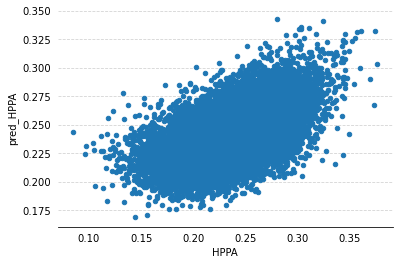

In [8]:
plt = limited.plot.scatter(x='HPPA', y='pred_HPPA')
adjust_plot(plt)

# Old Code

In [ ]:
# gl_leagues = gl[[
#     'GAME_ID', 'year', 'HomeTeamLeague', 'VisitingTeamLeague', 'HomeHR', 'VisitorHR', 'HomePA', 'VisitorPA'
# ]]
# gl_leagues.columns = [
#     'GAME_ID', 'year', 'LeagueHome', 'LeagueVisitor', 'HRHome', 'HRVisitor', 'PAHome', 'PAVisitor'
# ]
# gl_leagues_wide = pd.wide_to_long(gl_leagues, ['League', 'HR', 'PA'], i=['GAME_ID', 'year'], j='Type', suffix=r'\w+')

# LeagueHR = gl_leagues_wide.groupby(['League', 'year'])[['HR', 'PA']].sum()
# LeagueHR = LeagueHR[LeagueHR.index.get_level_values('League').isin(['AL','NL'])]
# LeagueHR.columns = ['LeagueHR', 'LeaguePA']

In [456]:
def marcel2(ser):
    base = merged.loc[ser.index]
    
    if len(base) == 1:
        hr = base['HR'].iloc[0]*5
        pa = base['PA'].iloc[0]*.5 + 200
        exp_hr = base['ExpHR'].iloc[0]*5
        exp_pa = base['PA'].iloc[0]*5
        y = base.index.get_level_values('year')[0]
        age = base['Age'].iloc[0]
    elif len(base) == 2:
        hr = base['HR'].iloc[1]*5 + base['HR'].iloc[0]*4
        pa = base['PA'].iloc[1]*.5 + base['PA'].iloc[0]*.1 + 200
        exp_hr = base['ExpHR'].iloc[1]*5 + base['ExpHR'].iloc[0]*4
        exp_pa = base['PA'].iloc[1]*5 + base['PA'].iloc[0]*4
        y = base.index.get_level_values('year')[1]
        age = base['Age'].iloc[1]
    else:
        hr = base['HR'].iloc[2]*5 + base['HR'].iloc[1]*4 + base['HR'].iloc[0]*3
        pa = base['PA'].iloc[2]*.5 + base['PA'].iloc[1]*.1 + 200
        exp_hr = base['ExpHR'].iloc[2]*5 + base['ExpHR'].iloc[1]*4 + base['ExpHR'].iloc[0]*3
        exp_pa = base['PA'].iloc[2]*5 + base['PA'].iloc[1]*4 + base['PA'].iloc[0]*3
        y = base.index.get_level_values('year')[2]
        age = base['Age'].iloc[2]
       
    adj_hr = (exp_hr / exp_pa)*1200
    tot_hr = hr + adj_hr
    tot_pa = 1200 + exp_pa
    exp_hr_per_pa = tot_hr / tot_pa
    
    proj_age = age + 1
    if proj_age < 29:
        age_adj = 1 + ((29 - proj_age)* .006)
    else:
        age_adj = 1 - ((29 - proj_age)* .003)
        
    proj_hr_per_pa = exp_hr_per_pa * age_adj
        
    return proj_hr_per_pa

In [451]:
harp = merged[merged.index.get_level_values('BAT_ID') == 'harpb003']
harp = harp.reset_index()
harp = harp.set_index('year')

In [457]:
merged = merged.reset_index()
merged = merged.set_index('year')

In [458]:
test = merged.groupby('BAT_ID')[['HR']].rolling(3, 1).apply(marcel2, raw=False)
test = test.sort_values(['BAT_ID', 'year'])
test['PredHRPA'] = test.groupby('BAT_ID')['HR'].shift(1)

del test['HR']
test

PredHRPA
BAT_ID   year          
aardd001 2006       NaN
         2008  0.023164
         2015  0.023164
aaroh101 1954       NaN
         1955  0.017902
...                 ...
zuvep001 1985  0.025117
         1986  0.019130
         1987  0.029819
         1988  0.024193
         1989  0.023938

[73450 rows x 1 columns]

In [462]:
test[test.index.get_level_values('BAT_ID') == 'harpb003']

PredHRPA
BAT_ID   year          
harpb003 2012       NaN
         2013  0.019965
         2014  0.019965
         2015  0.019965
         2016  0.015527
         2017  0.042201
         2018  0.041807
         2019  0.031711
         2020  0.042283